In [7]:
## importing all libraries for our models

# pandas
import pandas as pd

# tensorflow
import tensorflow as tf
from tensorflow import keras

# tensorflow.keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, AveragePooling1D
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, LSTM
from keras.layers import Concatenate, concatenate 
# Concatenate returns Concatenate object (layers), concatenate returns Tensor object (arrays)
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
from keras.layers.advanced_activations import LeakyReLU
#from tensorflow.keras.utils import plot_model

# numpy
import numpy as np
from numpy import random

# sklearn
import sklearn

# sklearn for pipeline mixins
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn for data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# sklearn for models
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from sklearn.preprocessing import normalize

# sklearn for model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import mean_squared_error
import sklearn.metrics.cluster as smc

# matplotlib.pyplot for plotting
from matplotlib import pyplot
import matplotlib.pyplot as plt 
import os

# misc
import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import pydot
import graphviz
from PIL import Image
import numpy as np
from numpy import random
import glob
import rasterio as rio
import scipy.io as sio
import glob
import json
import math

In [6]:
def get_max_wind(hurricane):
    name = hurricane + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']
    
    maxwind = -1
    maxwind_day = ''
    for path in paths:
        wind = float(path['maxwind'])
        if wind >= maxwind:
            maxwind = wind
            maxwind_day = path['date']
    return maxwind, maxwind_day  #  float, string

def wind_to_cat(wind_array):
    cats = []
    thresholds = [(0, 63), (1, 82), (2, 95), (3, 112), (4, 136), (5, 999)] # knots
    for wind in wind_array:
        for it in thresholds:
            if wind <= it[1]:
                category = it[0]
                break
        cats = np.append(cats, category)
    return cats
    
def get_imerg(imerg):
    # get imerg
    precips = glob.glob(imerg, recursive = True)
    precips.sort()
    print (precips, " precips: ", temperatures)
    imerg_array = np.load(precips[0])
    
    for file in precips[1:10]:
        load = np.load(file)
        print(file, load.shape)
        imerg_array = np.append(imerg_array, load, axis = 0)
    imerg_array = imerg_array.reshape(1, 10, 200, 200)
    
    return imerg_array

def get_sst(sst):
    # get sst
    temperatures = glob.glob(sst, recursive = True)
    print (sst, " temperatures: ", temperatures)
    temperatures.sort()
    sst_array = np.load(temperatures[0])
    
    for file in temperatures[1:4]:
        sst_array = np.append(sst_array, np.load(file), axis = 0)
    sst_array = sst_array.reshape(1, 4, 200, 200)
    
    return sst_array

def get_rgb(rgb):
    # get wavelet decomposed rgb
    colors = glob.glob(rgb, recursive = True)
    #print (colors, " rgbs: ", temperatures)
    colors.sort()
    rgb_array = np.load(colors[0])
    
    for file in colors[1:4]:
        rgb_array = np.append(rgb_array, np.load(file), axis = 0)
    
    rgb_array = rgb_array[:, :200, :200]
    rgb_array = rgb_array.reshape(1, 48, 200, 200)
    
    return rgb_array

def lenCheck(imerg, sst, rgb):
    imergs = glob.glob(imerg)
    ssts = glob.glob(sst)
    rgbs = glob.glob(rgb)
    
    if len(imergs) < 10 or len(ssts) < 4 or len(rgbs) < 4:
        return False
    else:
        return True
    
def landCheck(folder, imerg, sst, rgb):
    name = folder + '/profile.json'
    f = open(name)
    profile = json.load(f)
    paths = profile['path']

    valid_dates = []
    for path in paths:
        valid_dates = np.append(valid_dates, str(path['date']))
        
    file = folder + '/noaa_sst_*.npy'

    sst = glob.glob(file, recursive = True)
    sst.sort()
    sst = sst[0:4]
    
    valid = True

    days = []

    for imerg in imergs:
        days = np.append(days, sst[-17:-9])

    for day in days:
        if day not in valid_dates:
            valid = False
        else:
            valid = True

    return valid
    
def createWindMap(profile):
    # return nparray(1, 200, 200)
    # hurricane center is  at (99,99),   each direction expand by 100 miles
    
    res = np.zeros((200, 200))
    
    maxwindradius = min(int(float(profile['maxwindradius'])), 99)
    maxwind = float(profile['maxwind'])
    
    keys = []
    for it in profile.keys():
        if 'kt' in it:
            keys.append(it)        
    keys.sort()
    
    for it in keys:
        if "ne" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100-i-1,  100 +j] = max(0, float(it[:-4]))
        elif "se" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100 + i,  100 +j] = max(0, float(it[:-4]))
        elif "nw" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100-i-1,  100-j-1] = max(0, float(it[:-4]))
        elif "sw" in it:
            radius = min(int(float(profile[it])), 99)
            for i in range(0, radius):
                for j in range(0, radius):
                    res[100 + i,  100-j-1] = max(0, float(it[:-4]))
                        
    for i in range(-maxwindradius, maxwindradius):
        for j in range(-maxwindradius, maxwindradius):
            res[99 + i, 99 + j] = maxwind
    
    res = np.expand_dims(res, axis = 2)
                    
    return res
    

In [5]:
def getMaxWindDay(hurr_dict, day_list, peak_day):
    high_day = None
    high_wind = 0
    for day in day_list: # for every day in a category for a hurricane:
        wind_speeds = np.asarray([])
        for path in hurr_dict: # for every path record in that hurricane's profile.json:
            if day == str(path['date']): # if the days match:
                if (float(path['maxwind']) > high_wind) and (int(day) < int(peak_day)): # compare this day's max wind to the highest speed for this category
                    high_wind = float(path['maxwind'])
                    high_day = day
    
    return high_day

def getCategory(wind_speed): # based on the Saffir-Simpson Scale for hurricane classification
    
    thresholds = [('TD', 33), ('TS', 63), ('Category_1', 82), ('Category_2', 95), ('Category_3', 112), ('Category_4', 136)]
    
    for it in thresholds:
        if wind_speed <= it[1]:
            return it[0]
    return thresholds[-1][0]

def selectDay(hurr_dict, cat_dictionary, peak_day):
    pick_days = []
    for key in cat_dictionary.keys(): # for every category in the category dictionary:
        days = cat_dictionary[key]
        high_day = getMaxWindDay(hurr_dict, days, peak_day) # find day in each category with the highest average wind speed
        if high_day is not None:
            pick_days = np.append(pick_days, high_day) # pick the first (0th index) day of that category
    print("pick days:", pick_days)
    return pick_days # a 1-D array containing the first day that the hurricane reaches a new category.

def lastDay(hurr_dict):
    return None # will pick last day in path, 

def getStageByDay(folder, day):
    
    imerg_names = folder + '/imerg_precipitation_' + day + '_*.npy'
    sst_names = folder + '/noaa_sst_' + day + '*.npy'
    rgb_names = folder + '/10_wavelet_rgb_' + day + '*.npy'
    #rgb_names = folder + '/10_modis_satellite_' + day + '*.npy'
    
    profile_name = folder + '/profile.json'
    f = open(profile_name)
    profile = json.load(f)
    paths = profile['path']

    imergs = glob.glob(imerg_names, recursive = True)
    ssts = glob.glob(sst_names, recursive = True)
    rgbs = glob.glob(rgb_names, recursive = True)
    
    imerg_array = np.zeros((200, 200))
    for imerg in imergs:
        im_arr = np.load(imerg)
        if not (sizeCheck(im_arr)):
            continue
        imerg_array = imerg_array + np.load(imerg)

    imerg_array = imerg_array.reshape(200, 200, 1)
    imerg_array = imerg_array * 1000  # scale up rain preciptation by 1000
   

    if (not rgbs) or (not ssts):
        #print("no rgbs or ssts: ", folder, day)
        return None
    
    sst_array = np.load(ssts[0])
    
    if (not sizeCheck(sst_array)) or (not sizeCheck(imerg_array)):      
        #print("sst shape invalid: ", folder, day)
        return None

    sst_array = sst_array.reshape(200, 200, 1)
    
    sst_array[sst_array<0] = 0 # clean up negative(unintialized) sst values
    
    rgb_array = np.load(rgbs[0])
    
    #rgb_array = rgb_array[100:300, 100:300, :]
    rgb_array = rgb_array[1:201, 1:201, :]
    print(folder, day, "- rgb:", rgb_array.shape)
    rgb_array = ((rgb_array * 10000 + 100) / 66.66)*1.5


    rgb_array = rgb_array.astype(int)

    rgb_array[rgb_array < 0] = 0
    rgb_array[rgb_array > 255] = 255
        
    selected_days = []

    for path in paths:
        if path['date'] == int(day):
            selected_days.append(path)
        
    # pick mid element from path    
    middleIndex = int((len(selected_days) - 1)/2)
    if len(selected_days) == 2: 
        middleIndex = 1
        
    selected_day = selected_days[middleIndex]

    wind_array = createWindMap(selected_day)
    
    stage_array = imerg_array
    stage_array = np.dstack((stage_array, sst_array))
    stage_array = np.dstack((stage_array, rgb_array))
    stage_array = np.dstack((stage_array, wind_array))
    stage_array = np.expand_dims(stage_array, axis = 0)
    
    return stage_array

def sizeCheck(tensor): # size check should happen after stage data is collected
    shape = len(tensor.flatten())
    if shape != 40000:
        return False
    else:
        return True
    
def populateStage(stage, step):
    if step is None:
        return stage
    if stage is None:
        stage = step
    else:
        stage = np.append(stage, step, axis = 0)
    return stage

In [4]:
def completeDataCollection(globname, img_size, min_wind, max_wind, stage_or_day, day_start_index=0): # NEW DATA COLLECTION METHOD - SORT INTO STAGES
    """
    params:
        globname - folder names to glob
        img_size - shape of image
        max_wind - min wind to pick
        max_wind - max wind to pick
        stage_or_day  - True: pick first 3 stages,   False:  pick 3 days
        day_start_index   - first day to start with     
    """

    folders = glob.glob(globname, recursive = True)
    # AL032000, failed rgb glob (no modis satellite data for that day)
    # AL242005, failed ssts glob (no sst satellite data for that day)
    stage_1 = None
    stage_2 = None
    stage_3 = None
    highest_winds = None

    for folder in folders:
    
        name = folder + '/profile.json'
        f = open(name)
        prof = json.load(f)
        paths = prof['path']
        hurricane_days = []
        
        highest_wind, highest_wind_day = get_max_wind(folder)
        
        if highest_wind < min_wind or highest_wind >max_wind:
            print ('skipping ', folder, ' not in wind range' )
            continue
        
        print(folder, highest_wind, highest_wind_day)
   
        cats = {} # dictionary with categories as keys, days as values.
        # used to extract day values based on hurricane category (stage)
        
        for path in paths:
            # getCategory will take the max wind of every day in a hurricane's path and turn it into a category
                # based on the Saffir-Simpson Scale
            test = getCategory(int(path['maxwind']))

            if test not in cats.keys():
                cats[test] = []
            cats[test].append(str(path['date']))
            hurricane_days.append(str(path['date']))

        for key in cats.keys():
            cats[key] = list(set(cats[key]))
            cats[key].sort()
            
        hurricane_days = list(set(hurricane_days))
        hurricane_days.sort()
        
        # the category dictionary is used to select a day
        days = []
        if (stage_or_day):
            days = selectDay(paths, cats, highest_wind_day) # pass the profile.json of the hurricane to selectDay
            # selectDay will then pass the profile to getMaxWindDay
            # getMaxWindDay will use the profile combined with the cat_dictionary to get the day with highest wind
            if len(days) < 3:
                #print("not enough categories: ", folder)
                continue
        else:
            days = hurricane_days[day_start_index:]
            if len(days) < 5:
                continue
                
        print ('hurrican days', hurricane_days)
        print ('selected days', days)

        # this is the part of the model that selects the category
        # the step before this, selectDays(cat_dictionary), takes the list of days in a hurricane,
            # which is already sorted with a dictionary by category, and picks the middle day in each category's list
            # to produce days, which is used in this step.
        step_1 = getStageByDay(folder, days[0]) # third last day (category)
        step_2 = getStageByDay(folder, days[1]) # second last
        step_3 = getStageByDay(folder, days[2]) # last (strongest category)
        
        if (step_1 is None) or (step_2 is None) or (step_3 is None):
            #print("size not fit: ", folder)
            continue
        
        highest_winds = np.append(highest_winds, highest_wind)
        
        stage_1 = populateStage(stage_1, step_1)
        stage_2 = populateStage(stage_2, step_2)
        stage_3 = populateStage(stage_3, step_3)
        
        print("APPENDED", folder)

        

    highest_winds = highest_winds[1:]
    
    # original tensor size along dimensions 1 and 2 is 200x200
    length = stage_1.shape[1]
    padding = int((length - img_size)/2)
    
    stage_1 = stage_1[:, padding:length-padding, padding:length-padding, :]
    stage_2 = stage_2[:, padding:length-padding, padding:length-padding, :]
    stage_3 = stage_3[:, padding:length-padding, padding:length-padding, :]
    
    print(#stage_1.shape, 
      #stage_2.shape,
      stage_3.shape, 
      highest_winds.shape
     )
    
    return stage_1, stage_2, stage_3, highest_winds



In [ ]:
#stage_1, stage_2, stage_3, highest_wind = completeDataCollection('/home/fun/data/AL*20*', 100, 0, True)
#stage_1, stage_2, stage_3, highest_wind = completeDataCollection('/home/fun/data/AL*20*', 100, 34, False)

In [ ]:
#highest_cat = wind_to_cat(highest_wind)
#print(highest_wind, highest_cat)

In [ ]:
# ohe_cats = np.zeros((len(highest_cat), int(highest_cat.max())))

# for idx, cat in enumerate(highest_cat): 
#     ohe_cats[idx, int(cat)-1] = 1
    
# transform highest category (1-5) into one-hot encoded array
# 1 --> [1, 0, 0, 0, 0]
# 5 --> [0, 0, 0, 0, 1]

# allows our neural network to perform multi-class classification with multiple output nodes
# softmax activation function will make the model output positive probabilities for each category

In [ ]:
# stages = [stage_1, stage_2, stage_3]

# for stage in stages:
#     for i in range(stage.shape[0]):
#         for j in range(stage.shape[3]):
#             scaler = StandardScaler()
#             scaler.fit(stage[i, :, :, j])
#             stage[i, :, :, j] = scaler.transform(stage[i, :, :, j])
        
# print(stage_1.shape, stage_2.shape, stage_3.shape)

In [ ]:
# highest_wind = highest_wind.astype("float32")

# stage_1 = stage_1.astype("float32")
# #stage_1 = np.swapaxes(stage_1, 1, 2)
# #stage_1 = np.swapaxes(stage_1, 2, 3)

# stage_2 = stage_2.astype("float32")
# #stage_2 = np.swapaxes(stage_2, 1, 2)
# #stage_2 = np.swapaxes(stage_2, 2, 3)

# stage_3 = stage_3.astype("float32")
# #stage_3 = np.swapaxes(stage_3, 1, 2)
# #stage_3 = np.swapaxes(stage_3, 2, 3)

# print(stage_1.shape, stage_2.shape, stage_3.shape)

In [71]:
# img
# indices = np.arange(0, stage_1.shape[0], 1)
# print(len(indices))
# #print(len(ohe_cats))

# index_train, index_test, y_idx_train, y_idx_test = train_test_split(
#     indices, indices, train_size = 0.8, random_state = 2389)

# stage_1_train = None
# stage_1_test = None

# for i in index_train: # get shuffled training datasets
#     if stage_1_train is None:
#         stage_1_train = stage_1[i:i+1, :, :, :] # i:i+1 to force shape of a 4D tensor, doesn't change index values
#         stage_2_train = stage_2[i:i+1, :, :, :]
#         stage_3_train = stage_3[i:i+1, :, :, :]
#         category_train = ohe_cats[i:i+1, :]
#         maxwind_train = highest_wind[i]
        
#     else:
#         stage_1_train = np.append(stage_1_train, stage_1[i:i+1, :, :, :], axis = 0)
#         stage_2_train = np.append(stage_2_train, stage_2[i:i+1, :, :, :], axis = 0)
#         stage_3_train = np.append(stage_3_train, stage_3[i:i+1, :, :, :], axis = 0)
#         category_train = np.append(category_train, ohe_cats[i:i+1, :], axis = 0)
#         maxwind_train = np.append(maxwind_train, highest_wind[i])

# for i in index_test: # get shuffled testing datasets
#     if stage_1_test is None:
#         stage_1_test = stage_1[i:i+1, :, :, :]
#         stage_2_test = stage_2[i:i+1, :, :, :]
#         stage_3_test = stage_3[i:i+1, :, :, :]
#         category_test = ohe_cats[i:i+1, :]
#         maxwind_test = highest_wind[i]
        
#     else:
#         stage_1_test = np.append(stage_1_test, stage_1[i:i+1, :, :, :], axis = 0)
#         stage_2_test = np.append(stage_2_test, stage_2[i:i+1, :, :, :], axis = 0)
#         stage_3_test = np.append(stage_3_test, stage_3[i:i+1, :, :, :], axis = 0)
#         category_test = np.append(category_train, ohe_cats[i:i+1, :], axis = 0)
#         maxwind_test = np.append(maxwind_test, highest_wind[i])
        

# print(stage_1_train.shape, len(y_train))
# print(stage_1_test.shape, len(y_test))

110
(88, 100, 100, 47) 88
(22, 100, 100, 47) 22


In [82]:
# stage_1_train, stage_1_test, \
# stage_2_train, stage_2_test,  \
# stage_3_train, stage_3_test, \
# category_train, category_test, \
# maxwind_train, maxwind_test \
# = train_test_split(
#     stage_1, stage_2, stage_3, ohe_cats, highest_wind, train_size = 0.8, random_state = 2389)

# print(stage_1_train.shape, stage_1_test.shape)
# print(stage_2_train.shape, stage_2_test.shape)
# print(category_train.shape, category_test.shape)
# print(maxwind_train.shape, maxwind_test.shape)


(88, 100, 100, 47) (22, 100, 100, 47)
(88, 100, 100, 47) (22, 100, 100, 47)
(88, 5) (22, 5)
(88,) (22,)


In [3]:
def create_stages(image_size, channels, num_of_stages):
    flat_list = []
    input_list = []
    for i in range(num_of_stages):
        it = {}
        it['input'] = Input(shape = (image_size, image_size, channels),
                      name = 'stage' + str(i+1) + '_input')

        it['conv'] = Conv2D(filters = 12, 
               kernel_size = (11, 11), 
               activation = "relu", 
               padding = "same", 
               name = 'stage' + str(i+1) + '_conv')(it['input'])

        it['pool'] = AveragePooling2D(pool_size = (2, 2), 
                         strides = 2,
                         name = 'stage' + str(i+1) + '_pool')(it['conv'])

        it['batch'] = BatchNormalization(name = 'stage' + str(i+1) +'_batch1')(it['pool'])

        it['conv2'] = Conv2D(filters = 12, 
               kernel_size = (11, 11), 
               activation = "relu", 
               padding = "same", 
               name = 'stage' + str(i+1) + '_conv2')(it['batch'])


        it['pool2'] = AveragePooling2D(pool_size = (2, 2), 
                         strides = 2,
                         name = 'stage' + str(i+1) + '_pool2')(it['conv2'])

        it['batch2'] = BatchNormalization(name = 'stage' + str(i+1) +'_batch2')(it['pool2'])

        it['flat']  = Flatten(name = 'stage' + str(i+1) + '_flat')(it['batch2'])

        flat_list.append(it['flat'])
        input_list.append(it['input'])

    return flat_list, input_list


def create_category_model(image_size, channels, num_of_stages):
    
    flat_list, input_list = create_stages(image_size, channels, num_of_stages)
        
    # dense layers -- feature training
    concat = concatenate(flat_list)

    dense1 = Dense(128, activation = keras.layers.LeakyReLU(alpha = 0.3), 
                   name = 'Fully_Connected_1', bias_initializer = tf.keras.initializers.Ones())(concat)
    dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

    dense2 = Dense(64, activation = keras.layers.LeakyReLU(alpha = 0.3),
                   name = 'Fully_Connected_2', bias_initializer = tf.keras.initializers.Ones())(dense1dropout)
    dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)
    
    output = Dense(5, activation = "softmax", 
                    name = 'Output_Layer', bias_initializer = tf.keras.initializers.Ones())(dense2dropout)

    # create model with two inputs
    model = Model(input_list, output)
    return model

def create_maxwind_model(image_size, channels, num_of_stages):    
    flat_list, input_list = create_stages(image_size, channels, num_of_stages)
        
    # dense layers -- feature training
    concat = concatenate(flat_list)

    dense1 = Dense(128, activation = 'relu', 
                   name = 'Fully_Connected_1', bias_initializer = tf.keras.initializers.Ones())(concat)
    dense1dropout = Dropout(0.5, name = 'Dense_Dropout_1')(dense1)

    dense2 = Dense(64, activation = 'relu',
                   name = 'Fully_Connected_2', bias_initializer = tf.keras.initializers.Ones())(dense1dropout)
    dense2dropout = Dropout(0.5, name = 'Dense_Dropout_2')(dense2)

    output = Dense(1, activation = 'relu', name = 'Output_Layer', bias_initializer = tf.keras.initializers.Ones())(dense2dropout)

    # create model with two inputs
    model = Model(input_list, output)
    return model

def category_compile(model, lr): #0.00001
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(), 
        optimizer = tf.keras.optimizers.SGD(
            learning_rate = lr,
        ),
        metrics = ['acc']
    )
        
def maxwind_compile(model, lr): #0.0005
    model.compile(
        loss = tf.keras.losses.MeanSquaredError(), 
        optimizer = tf.keras.optimizers.Adam(
            learning_rate = lr
        ),
        metrics = tf.keras.metrics.RootMeanSquaredError()
    )

def get_train_test_data(globname, img_size, min_wind, max_wind,  is_stage_mode, train_size, day_start_idx=0):
    
    stage_1, stage_2, stage_3, highest_wind = completeDataCollection(globname, img_size, min_wind, max_wind, is_stage_mode, day_start_idx)
    highest_cat = wind_to_cat(highest_wind)
    #generate wind category
    ohe_cats = np.zeros((len(highest_cat), int(highest_cat.max())))
    for idx, cat in enumerate(highest_cat): 
        ohe_cats[idx, int(cat)-1] = 1
        
    stages = [stage_1, stage_2, stage_3]

    for stage in stages:
        for i in range(stage.shape[0]):
            for j in range(stage.shape[3]):
                scaler = StandardScaler()
                scaler.fit(stage[i, :, :, j])
                stage[i, :, :, j] = scaler.transform(stage[i, :, :, j])
                
    
    highest_wind = highest_wind.astype("float32")
    stage_1 = stage_1.astype("float32")
    stage_2 = stage_2.astype("float32")
    stage_3 = stage_3.astype("float32")
    
    return train_test_split(stage_1, stage_2, stage_3, ohe_cats, highest_wind, train_size = train_size, random_state = 2389)

def fit_category_3_stage_model(lr, epochs, stage_1_train, stage_2_train, stage_3_train, category_train,\
                          stage_1_test, stage_2_test, stage_3_test, category_test):
    category_three_stage_model = create_category_model(100, 47, 3)
    category_compile(category_three_stage_model, lr)
    history = category_three_stage_model.fit([
        stage_1_train, 
        stage_2_train, 
        stage_3_train
    ], category_train, 
              batch_size = 5, 
              epochs = epochs, 
              validation_data = ([
                  stage_1_test, 
                  stage_2_test, 
                  stage_3_test
              ], category_test), 
              )
    return category_three_stage_model

    
def fit_maxwind_3_stage_model(lr, epochs, stage_1_train, stage_2_train, stage_3_train, maxwind_train,\
                          stage_1_test, stage_2_test, stage_3_test, maxwind_test):
    maxwind_three_stage_model = create_maxwind_model(100, 47, 3)
    maxwind_compile(maxwind_three_stage_model, lr)
    history = maxwind_three_stage_model.fit([
        stage_1_train, 
        stage_2_train, 
        stage_3_train
    ], maxwind_train, 
              batch_size = 5, 
              epochs = epochs, 
              validation_data = ([
                  stage_1_test, 
                  stage_2_test, 
                  stage_3_test
              ], maxwind_test), 
              )    
    return maxwind_three_stage_model
# for MULTICLASS EVALUATION ONLY

def softmaxToCat(y_pred):
    res = []
    for row in y_pred:
        res = np.append(res, row.argmax()+1)
    return res

def draw_confusion_matrix(y, yhat, classes, title):
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    #plt.title("strongest 3 stages, strongest day - confusion matrix")
    plt.title(title)
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)

    fmt = 'd'
    thresh = matrix.max() / 5.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    plt.show()
        
def category_predict(model, stage_list, y_true, title):
    y_pred = model.predict(stage_list)

    y_pred_res = softmaxToCat(y_pred)
    y_true_res = softmaxToCat(y_true)

    print(y_true_res, y_pred_res)
    draw_confusion_matrix(y_true_res, y_pred_res, ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5'], title)
    print(classification_report(y_true_res, y_pred_res, zero_division = True))
    
def maxwind_predict(model, stage_list, actual, title):
    y_pred = model.predict(stage_list)
    y_pred = y_pred.reshape(y_pred.shape[0])

    y_test = actual

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(y_test, y_pred, s=30, c='b', marker="s", label='predicted')
    ax1.scatter(y_test, y_test, s=30, c='r', marker="o", label='actual')
    #plt.title("strongest 3 stages, strongest day - validation phase")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    
    get_percent_error(y_test, y_pred)
    get_RMSE(y_test, y_pred)
    
def get_percent_error(y_test, y_pred):
    percent_error = 0
    err_vals = []

    for i in range(len(y_test)):
        err = ((y_pred[i] - y_test[i])/y_pred[i])*100
        err_vals = np.append(err_vals, abs(err))
        percent_error = percent_error + abs(err)

    mean_error = percent_error/len(y_test)

    print("on average, the model's prediction is", mean_error, "% off of the true max wind speed.")

def get_RMSE(y_test, y_pred):
    print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)), "knots")
        

In [15]:

#first 3 stages
stage_1_train, stage_1_test, \
stage_2_train, stage_2_test,  \
stage_3_train, stage_3_test, \
stage_category_train, stage_category_test, \
stage_maxwind_train, stage_maxwind_test = get_train_test_data('/home/fun/data/AL*20*', 100, 0, 200, True, 0.7)


#first 3 days
test1 = {}
test1['day_1_train'], test1['day_1_test'], \
test1['day_2_train'], test1['day_2_test'],  \
test1['day_3_train'], test1['day_3_test'], \
test1['day_category_train'], test1['day_category_test'], \
test1['day_maxwind_train'], test1['day_maxwind_test'] = get_train_test_data('/home/fun/data/AL*20*', 100, 0, 200, False, 0.7, 0)

#2,3,4
test2 = {}
test2['day_1_train'], test2['day_1_test'], \
test2['day_2_train'], test2['day_2_test'],  \
test2['day_3_train'], test2['day_3_test'], \
test2['day_category_train'], test2['day_category_test'], \
test2['day_maxwind_train'], test2['day_maxwind_test'] = get_train_test_data('/home/fun/data/AL*20*', 100, 0, 200, False, 0.7, 1)

#3,4,5
test3 = {}
test3['day_1_train'], test3['day_1_test'], \
test3['day_2_train'], test3['day_2_test'],  \
test3['day_3_train'], test3['day_3_test'], \
test3['day_category_train'], test3['day_category_test'], \
test3['day_maxwind_train'], test3['day_maxwind_test'] = get_train_test_data('/home/fun/data/AL*20*', 100, 0, 200, False, 0.7, 2)


/home/fun/data/AL022004 55.0 20040811
pick days: ['20040809' '20040810']
/home/fun/data/AL042004 95.0 20040817
pick days: ['20040813' '20040814' '20040815' '20040816']
hurrican days ['20040813', '20040814', '20040815', '20040816', '20040817', '20040818', '20040819', '20040820', '20040821', '20040822', '20040823', '20040824']
selected days ['20040813' '20040814' '20040815' '20040816']
/home/fun/data/AL042004 20040814 - rgb: (200, 200, 44)
/home/fun/data/AL042004 20040815 - rgb: (200, 200, 44)
/home/fun/data/AL052004 45.0 20040815
pick days: ['20040814' '20040814']
/home/fun/data/AL072004 65.0 20040829
pick days: ['20040828' '20040828']
/home/fun/data/AL082004 50.0 20040830
pick days: ['20040829' '20040829']
/home/fun/data/AL102004 30.0 20040910
pick days: ['20040909']
/home/fun/data/AL112004 25.0 20040914
pick days: ['20040913']
/home/fun/data/AL072006 80.0 20060911
pick days: ['20060905' '20060910' '20060910']
hurrican days ['20060903', '20060904', '20060905', '20060906', '20060907', '

APPENDED /home/fun/data/AL152001
/home/fun/data/AL162001 65.0 20011105
pick days: ['20011104']
/home/fun/data/AL172001 80.0 20011127
pick days: ['20011123' '20011126' '20011126']
hurrican days ['20011123', '20011124', '20011125', '20011126', '20011127', '20011128', '20011129', '20011130', '20011201', '20011202', '20011203', '20011204']
selected days ['20011123' '20011126' '20011126']
/home/fun/data/AL172001 20011123 - rgb: (200, 200, 44)
/home/fun/data/AL172001 20011126 - rgb: (200, 200, 44)
/home/fun/data/AL172001 20011126 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL172001
/home/fun/data/AL012002 50.0 20020717
pick days: ['20020715' '20020716']
/home/fun/data/AL022002 35.0 20020805
pick days: ['20020804']
/home/fun/data/AL032002 45.0 20020808
pick days: ['20020806' '20020807']
/home/fun/data/AL042002 50.0 20020830
pick days: ['20020829' '20020829']
/home/fun/data/AL052002 55.0 20020903
pick days: ['20020902' '20020902']
/home/fun/data/AL062002 50.0 20020907
pick days: ['20020905' 

APPENDED /home/fun/data/AL092004
/home/fun/data/AL122004 125.0 20040921
pick days: ['20040916' '20040917' '20040918' '20040919' '20040920' '20040920']
hurrican days ['20040916', '20040917', '20040918', '20040919', '20040920', '20040921', '20040922', '20040923', '20040924', '20040925', '20040926', '20040927', '20040928']
selected days ['20040916' '20040917' '20040918' '20040919' '20040920' '20040920']
/home/fun/data/AL122004 20040916 - rgb: (200, 200, 44)
/home/fun/data/AL122004 20040917 - rgb: (200, 200, 44)
/home/fun/data/AL122004 20040918 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL122004
/home/fun/data/AL132004 65.0 20041002
pick days: ['20040920' '20040921']
/home/fun/data/AL142004 40.0 20041010
pick days: ['20041008' '20041009']
/home/fun/data/AL152004 45.0 20041011
pick days: ['20041010']
/home/fun/data/AL162004 45.0 20041130
pick days: ['20041126' '20041129']
/home/fun/data/AL012005 60.0 20050611
pick days: ['20050609' '20050610']
/home/fun/data/AL022005 35.0 20050629
pick d

APPENDED /home/fun/data/AL042007
/home/fun/data/AL052007 35.0 20070816
pick days: ['20070815' '20070815']
/home/fun/data/AL062007 40.0 20070901
pick days: ['20070831']
/home/fun/data/AL072007 50.0 20070909
pick days: ['20070908']
/home/fun/data/AL082007 40.0 20070914
pick days: ['20070913' '20070913']
/home/fun/data/AL092007 80.0 20070913
pick days: ['20070912' '20070912']
/home/fun/data/AL102007 30.0 20070921
pick days: []
/home/fun/data/AL112007 35.0 20070924
pick days: ['20070923' '20070923']
/home/fun/data/AL122007 65.0 20070926
pick days: ['20070925' '20070925']
/home/fun/data/AL132007 70.0 20070928
pick days: ['20070927' '20070927']
/home/fun/data/AL142007 35.0 20070930
pick days: ['20070929' '20070929']
/home/fun/data/AL152007 45.0 20071017
pick days: ['20071016' '20071016']
/home/fun/data/AL162007 75.0 20071103
pick days: ['20071028' '20071101' '20071102']
hurrican days ['20071024', '20071025', '20071026', '20071027', '20071028', '20071029', '20071030', '20071031', '20071101', 

/home/fun/data/AL132010 55.0 20100915
pick days: ['20100914' '20100914']
/home/fun/data/AL142010 75.0 20100925
pick days: ['20100922' '20100924' '20100924']
hurrican days ['20100920', '20100921', '20100922', '20100923', '20100924', '20100925', '20100926', '20100927', '20100928', '20100929']
selected days ['20100922' '20100924' '20100924']
/home/fun/data/AL142010 20100922 - rgb: (200, 200, 44)
/home/fun/data/AL142010 20100924 - rgb: (200, 200, 44)
/home/fun/data/AL142010 20100924 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL142010
/home/fun/data/AL152010 50.0 20100924
pick days: ['20100923' '20100923']
/home/fun/data/AL162010 40.0 20100930
pick days: ['20100928' '20100928']
/home/fun/data/AL172010 75.0 20101009
pick days: ['20101006' '20101008' '20101008']
hurrican days ['20101006', '20101007', '20101008', '20101009', '20101010', '20101011', '20101012', '20101013', '20101014', '20101015', '20101016', '20101017']
selected days ['20101006' '20101008' '20101008']
/home/fun/data/AL172010

APPENDED /home/fun/data/AL132012
/home/fun/data/AL142012 80.0 20120930
pick days: ['20120911' '20120914' '20120915']
hurrican days ['20120910', '20120911', '20120912', '20120913', '20120914', '20120915', '20120916', '20120917', '20120918', '20120919', '20120920', '20120921', '20120922', '20120923', '20120924', '20120925', '20120926', '20120927', '20120928', '20120929', '20120930', '20121001', '20121002', '20121003', '20121004']
selected days ['20120911' '20120914' '20120915']
/home/fun/data/AL142012 20120911 - rgb: (200, 200, 44)
/home/fun/data/AL142012 20120914 - rgb: (200, 200, 44)
/home/fun/data/AL142012 20120915 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL142012
/home/fun/data/AL152012 45.0 20121005
pick days: ['20121003' '20121004']
/home/fun/data/AL162012 40.0 20121012
pick days: ['20121011' '20121011']
/home/fun/data/AL172012 80.0 20121016
pick days: ['20121015' '20121015']
/home/fun/data/AL182012 100.0 20121025
pick days: ['20121022' '20121024' '20121024']
hurrican days ['2

APPENDED /home/fun/data/AL142016
/home/fun/data/AL152016 120.0 20161013
pick days: ['20161007' '20161012' '20161012' '20161012']
hurrican days ['20161004', '20161005', '20161006', '20161007', '20161008', '20161009', '20161010', '20161011', '20161012', '20161013', '20161014', '20161015', '20161016', '20161017', '20161018', '20161019']
selected days ['20161007' '20161012' '20161012' '20161012']
/home/fun/data/AL152016 20161007 - rgb: (200, 200, 44)
/home/fun/data/AL152016 20161012 - rgb: (200, 200, 44)
/home/fun/data/AL152016 20161012 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL152016
/home/fun/data/AL162016 100.0 20161124
pick days: ['20161121' '20161123' '20161123']
hurrican days ['20161117', '20161118', '20161119', '20161120', '20161121', '20161122', '20161123', '20161124']
selected days ['20161121' '20161123' '20161123']
/home/fun/data/AL162016 20161121 - rgb: (200, 200, 44)
/home/fun/data/AL162016 20161123 - rgb: (200, 200, 44)
/home/fun/data/AL162016 20161123 - rgb: (200, 200, 

APPENDED /home/fun/data/AL092019
/home/fun/data/AL102019 90.0 20190920
pick days: ['20190918' '20190919' '20190919']
hurrican days ['20190917', '20190918', '20190919', '20190920', '20190921', '20190922', '20190923', '20190924', '20190925', '20190926', '20190927', '20190928']
selected days ['20190918' '20190919' '20190919']
/home/fun/data/AL102019 20190918 - rgb: (200, 200, 44)
/home/fun/data/AL102019 20190919 - rgb: (200, 200, 44)
/home/fun/data/AL102019 20190919 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL102019
/home/fun/data/AL112019 35.0 20190917
pick days: []
/home/fun/data/AL122019 40.0 20190926
pick days: ['20190924' '20190924']
/home/fun/data/AL132019 140.0 20190929
pick days: ['20190923' '20190925' '20190925' '20190926' '20190927' '20190927']
hurrican days ['20190922', '20190923', '20190924', '20190925', '20190926', '20190927', '20190928', '20190929', '20190930', '20191001', '20191002', '20191003', '20191004']
selected days ['20190923' '20190925' '20190925' '20190926' '201

/home/fun/data/AL182021 20210924 - rgb: (200, 200, 44)
/home/fun/data/AL182021 20210924 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL182021
/home/fun/data/AL192021 40.0 20210925
pick days: ['20210924' '20210924']
/home/fun/data/AL202021 55.0 20211001
pick days: ['20210929' '20210930']
/home/fun/data/AL212021 60.0 20211027
pick days: ['20211026']
(85, 100, 100, 47) (85,)
/home/fun/data/AL022004 55.0 20040811
hurrican days ['20040803', '20040804', '20040805', '20040806', '20040807', '20040808', '20040809', '20040810', '20040811', '20040812']
selected days ['20040803', '20040804', '20040805', '20040806', '20040807', '20040808', '20040809', '20040810', '20040811', '20040812']
/home/fun/data/AL022004 20040803 - rgb: (200, 200, 44)
/home/fun/data/AL022004 20040804 - rgb: (200, 200, 44)
/home/fun/data/AL022004 20040805 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL022004
/home/fun/data/AL042004 95.0 20040817
hurrican days ['20040813', '20040814', '20040815', '20040816', '20040817', '2004

APPENDED /home/fun/data/AL042001
/home/fun/data/AL052001 60.0 20010828
hurrican days ['20010822', '20010823', '20010824', '20010825', '20010826', '20010827', '20010828', '20010829']
selected days ['20010822', '20010823', '20010824', '20010825', '20010826', '20010827', '20010828', '20010829']
/home/fun/data/AL052001 20010822 - rgb: (200, 200, 44)
/home/fun/data/AL052001 20010823 - rgb: (200, 200, 44)
/home/fun/data/AL052001 20010824 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL052001
/home/fun/data/AL062001 105.0 20010910
hurrican days ['20010901', '20010902', '20010903', '20010904', '20010905', '20010906', '20010907', '20010908', '20010909', '20010910', '20010911', '20010912', '20010913', '20010914', '20010915', '20010916', '20010917']
selected days ['20010901', '20010902', '20010903', '20010904', '20010905', '20010906', '20010907', '20010908', '20010909', '20010910', '20010911', '20010912', '20010913', '20010914', '20010915', '20010916', '20010917']
/home/fun/data/AL062001 20010901

APPENDED /home/fun/data/AL132002
/home/fun/data/AL142002 30.0 20021016
/home/fun/data/AL012003 50.0 20030422
hurrican days ['20030418', '20030419', '20030420', '20030421', '20030422', '20030423', '20030424', '20030425', '20030426', '20030427']
selected days ['20030418', '20030419', '20030420', '20030421', '20030422', '20030423', '20030424', '20030425', '20030426', '20030427']
/home/fun/data/AL012003 20030418 - rgb: (200, 200, 44)
/home/fun/data/AL012003 20030419 - rgb: (200, 200, 44)
/home/fun/data/AL012003 20030420 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL012003
/home/fun/data/AL022003 30.0 20030611
/home/fun/data/AL032003 50.0 20030630
/home/fun/data/AL042003 70.0 20030710
hurrican days ['20030707', '20030708', '20030709', '20030710', '20030711']
selected days ['20030707', '20030708', '20030709', '20030710', '20030711']
/home/fun/data/AL042003 20030707 - rgb: (200, 200, 44)
/home/fun/data/AL042003 20030708 - rgb: (200, 200, 44)
/home/fun/data/AL042003 20030709 - rgb: (200, 200

APPENDED /home/fun/data/AL092004
/home/fun/data/AL122004 125.0 20040921
hurrican days ['20040916', '20040917', '20040918', '20040919', '20040920', '20040921', '20040922', '20040923', '20040924', '20040925', '20040926', '20040927', '20040928']
selected days ['20040916', '20040917', '20040918', '20040919', '20040920', '20040921', '20040922', '20040923', '20040924', '20040925', '20040926', '20040927', '20040928']
/home/fun/data/AL122004 20040916 - rgb: (200, 200, 44)
/home/fun/data/AL122004 20040917 - rgb: (200, 200, 44)
/home/fun/data/AL122004 20040918 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL122004
/home/fun/data/AL132004 65.0 20041002
hurrican days ['20040919', '20040920', '20040921', '20040922', '20040923', '20040924', '20040925', '20040926', '20040927', '20040928', '20040929', '20040930', '20041001', '20041002', '20041003']
selected days ['20040919', '20040920', '20040921', '20040922', '20040923', '20040924', '20040925', '20040926', '20040927', '20040928', '20040929', '2004093

APPENDED /home/fun/data/AL282005
/home/fun/data/AL292005 60.0 20051128
hurrican days ['20051119', '20051120', '20051121', '20051122', '20051123', '20051124', '20051125', '20051126', '20051127', '20051128', '20051129']
selected days ['20051119', '20051120', '20051121', '20051122', '20051123', '20051124', '20051125', '20051126', '20051127', '20051128', '20051129']
/home/fun/data/AL292005 20051119 - rgb: (200, 200, 44)
/home/fun/data/AL292005 20051120 - rgb: (200, 200, 44)
/home/fun/data/AL292005 20051121 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL292005
/home/fun/data/AL302005 75.0 20051205
hurrican days ['20051129', '20051130', '20051201', '20051202', '20051203', '20051204', '20051205', '20051206', '20051207', '20051208', '20051209']
selected days ['20051129', '20051130', '20051201', '20051202', '20051203', '20051204', '20051205', '20051206', '20051207', '20051208', '20051209']
/home/fun/data/AL312005 55.0 20060104
hurrican days ['20051230', '20051231', '20060101', '20060102', '200

APPENDED /home/fun/data/AL172007
/home/fun/data/AL012008 40.0 20080531
/home/fun/data/AL022008 110.0 20080707
hurrican days ['20080703', '20080704', '20080705', '20080706', '20080707', '20080708', '20080709', '20080710', '20080711', '20080712', '20080713', '20080714', '20080715', '20080716', '20080717', '20080718', '20080719', '20080720', '20080721']
selected days ['20080703', '20080704', '20080705', '20080706', '20080707', '20080708', '20080709', '20080710', '20080711', '20080712', '20080713', '20080714', '20080715', '20080716', '20080717', '20080718', '20080719', '20080720', '20080721']
/home/fun/data/AL022008 20080703 - rgb: (200, 200, 44)
/home/fun/data/AL022008 20080704 - rgb: (200, 200, 44)
/home/fun/data/AL022008 20080705 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL022008
/home/fun/data/AL032008 55.0 20080722
hurrican days ['20080719', '20080720', '20080721', '20080722', '20080723']
selected days ['20080719', '20080720', '20080721', '20080722', '20080723']
/home/fun/data/AL0

APPENDED /home/fun/data/AL042010
/home/fun/data/AL052010 30.0 20100811
hurrican days ['20100810', '20100811', '20100812', '20100813', '20100814', '20100815', '20100816', '20100817', '20100818']
selected days ['20100810', '20100811', '20100812', '20100813', '20100814', '20100815', '20100816', '20100817', '20100818']
/home/fun/data/AL052010 20100810 - rgb: (200, 200, 44)
/home/fun/data/AL052010 20100811 - rgb: (200, 200, 44)
/home/fun/data/AL052010 20100812 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL052010
/home/fun/data/AL062010 115.0 20100827
hurrican days ['20100821', '20100822', '20100823', '20100824', '20100825', '20100826', '20100827', '20100828', '20100829', '20100830', '20100831', '20100901', '20100902', '20100903']
selected days ['20100821', '20100822', '20100823', '20100824', '20100825', '20100826', '20100827', '20100828', '20100829', '20100830', '20100831', '20100901', '20100902', '20100903']
/home/fun/data/AL062010 20100821 - rgb: (200, 200, 44)
/home/fun/data/AL062010 2

APPENDED /home/fun/data/AL142011
/home/fun/data/AL152011 65.0 20110909
hurrican days ['20110906', '20110907', '20110908', '20110909', '20110910', '20110911']
selected days ['20110906', '20110907', '20110908', '20110909', '20110910', '20110911']
/home/fun/data/AL152011 20110906 - rgb: (200, 200, 44)
/home/fun/data/AL152011 20110907 - rgb: (200, 200, 44)
/home/fun/data/AL152011 20110908 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL152011
/home/fun/data/AL162011 120.0 20111002
hurrican days ['20110920', '20110921', '20110922', '20110923', '20110924', '20110925', '20110926', '20110927', '20110928', '20110929', '20110930', '20111001', '20111002', '20111003', '20111004']
selected days ['20110920', '20110921', '20110922', '20110923', '20110924', '20110925', '20110926', '20110927', '20110928', '20110929', '20110930', '20111001', '20111002', '20111003', '20111004']
/home/fun/data/AL162011 20110920 - rgb: (200, 200, 44)
/home/fun/data/AL162011 20110921 - rgb: (200, 200, 44)
/home/fun/data/AL1

APPENDED /home/fun/data/AL142012
/home/fun/data/AL152012 45.0 20121005
/home/fun/data/AL162012 40.0 20121012
/home/fun/data/AL172012 80.0 20121016
hurrican days ['20121012', '20121013', '20121014', '20121015', '20121016', '20121017', '20121018', '20121019', '20121020', '20121021', '20121022', '20121023', '20121024', '20121025', '20121026']
selected days ['20121012', '20121013', '20121014', '20121015', '20121016', '20121017', '20121018', '20121019', '20121020', '20121021', '20121022', '20121023', '20121024', '20121025', '20121026']
/home/fun/data/AL172012 20121012 - rgb: (200, 200, 44)
/home/fun/data/AL172012 20121013 - rgb: (200, 200, 44)
/home/fun/data/AL172012 20121014 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL172012
/home/fun/data/AL182012 100.0 20121025
hurrican days ['20121021', '20121022', '20121023', '20121024', '20121025', '20121026', '20121027', '20121028', '20121029']
selected days ['20121021', '20121022', '20121023', '20121024', '20121025', '20121026', '20121027', '201

APPENDED /home/fun/data/AL062014
/home/fun/data/AL072014 65.0 20141012
/home/fun/data/AL082014 65.0 20141013
/home/fun/data/AL092014 35.0 20141027
hurrican days ['20141021', '20141022', '20141023', '20141024', '20141025', '20141026', '20141027']
selected days ['20141021', '20141022', '20141023', '20141024', '20141025', '20141026', '20141027']
/home/fun/data/AL092014 20141021 - rgb: (200, 200, 44)
/home/fun/data/AL092014 20141022 - rgb: (200, 200, 44)
/home/fun/data/AL092014 20141023 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL092014
/home/fun/data/AL012015 50.0 20150509
hurrican days ['20150506', '20150507', '20150508', '20150509', '20150510']
selected days ['20150506', '20150507', '20150508', '20150509', '20150510']
/home/fun/data/AL012015 20150506 - rgb: (200, 200, 44)
/home/fun/data/AL012015 20150507 - rgb: (200, 200, 44)
/home/fun/data/AL012015 20150508 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL012015
/home/fun/data/AL022015 50.0 20150616
/home/fun/data/AL032015 45.0 2015

APPENDED /home/fun/data/AL132016
/home/fun/data/AL142016 145.0 20161001
hurrican days ['20160928', '20160929', '20160930', '20161001', '20161002', '20161003', '20161004', '20161005', '20161006']
selected days ['20160928', '20160929', '20160930', '20161001', '20161002', '20161003', '20161004', '20161005', '20161006']
/home/fun/data/AL142016 20160928 - rgb: (200, 200, 44)
/home/fun/data/AL142016 20160929 - rgb: (200, 200, 44)
/home/fun/data/AL142016 20160930 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL142016
/home/fun/data/AL152016 120.0 20161013
hurrican days ['20161004', '20161005', '20161006', '20161007', '20161008', '20161009', '20161010', '20161011', '20161012', '20161013', '20161014', '20161015', '20161016', '20161017', '20161018', '20161019']
selected days ['20161004', '20161005', '20161006', '20161007', '20161008', '20161009', '20161010', '20161011', '20161012', '20161013', '20161014', '20161015', '20161016', '20161017', '20161018', '20161019']
/home/fun/data/AL152016 2016100

/home/fun/data/AL042019 20190822 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL042019
/home/fun/data/AL052019 45.0 20190827
/home/fun/data/AL062019 35.0 20190829
/home/fun/data/AL072019 45.0 20190904
/home/fun/data/AL082019 55.0 20190909
hurrican days ['20190903', '20190904', '20190905', '20190906', '20190907', '20190908', '20190909', '20190910', '20190911']
selected days ['20190903', '20190904', '20190905', '20190906', '20190907', '20190908', '20190909', '20190910', '20190911']
/home/fun/data/AL082019 20190903 - rgb: (200, 200, 44)
/home/fun/data/AL082019 20190904 - rgb: (200, 200, 44)
/home/fun/data/AL082019 20190905 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL082019
/home/fun/data/AL092019 110.0 20190919
hurrican days ['20190912', '20190913', '20190914', '20190915', '20190916', '20190917', '20190918', '20190919', '20190920']
selected days ['20190912', '20190913', '20190914', '20190915', '20190916', '20190917', '20190918', '20190919', '20190920']
/home/fun/data/AL092019 2019091

APPENDED /home/fun/data/AL152020
/home/fun/data/AL162020 65.0 20200903
/home/fun/data/AL172020 80.0 20200914
hurrican days ['20200907', '20200908', '20200909', '20200910', '20200911', '20200912', '20200913', '20200914']
selected days ['20200907', '20200908', '20200909', '20200910', '20200911', '20200912', '20200913', '20200914']
/home/fun/data/AL172020 20200907 - rgb: (200, 200, 44)
/home/fun/data/AL172020 20200908 - rgb: (200, 200, 44)
/home/fun/data/AL172020 20200909 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL172020
/home/fun/data/AL182020 40.0 20200910
hurrican days ['20200906', '20200907', '20200908', '20200909', '20200910', '20200911', '20200912', '20200913', '20200914']
selected days ['20200906', '20200907', '20200908', '20200909', '20200910', '20200911', '20200912', '20200913', '20200914']
/home/fun/data/AL182020 20200908 - rgb: (200, 200, 44)
/home/fun/data/AL192020 30.0 20200912
/home/fun/data/AL202020 120.0 20200918
hurrican days ['20200912', '20200913', '20200914', '202

APPENDED /home/fun/data/AL152021
/home/fun/data/AL162021 45.0 20210921
/home/fun/data/AL172021 50.0 20210921
hurrican days ['20210919', '20210920', '20210921', '20210922', '20210923', '20210924']
selected days ['20210919', '20210920', '20210921', '20210922', '20210923', '20210924']
/home/fun/data/AL172021 20210919 - rgb: (200, 200, 44)
/home/fun/data/AL172021 20210920 - rgb: (200, 200, 44)
/home/fun/data/AL172021 20210921 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL172021
/home/fun/data/AL182021 135.0 20210926
hurrican days ['20210922', '20210923', '20210924', '20210925', '20210926', '20210927', '20210928', '20210929', '20210930', '20211001', '20211002', '20211003', '20211004', '20211005', '20211006', '20211007']
selected days ['20210922', '20210923', '20210924', '20210925', '20210926', '20210927', '20210928', '20210929', '20210930', '20211001', '20211002', '20211003', '20211004', '20211005', '20211006', '20211007']
/home/fun/data/AL182021 20210922 - rgb: (200, 200, 44)
/home/fun/d

APPENDED /home/fun/data/AL042001
/home/fun/data/AL052001 60.0 20010828
hurrican days ['20010822', '20010823', '20010824', '20010825', '20010826', '20010827', '20010828', '20010829']
selected days ['20010823', '20010824', '20010825', '20010826', '20010827', '20010828', '20010829']
/home/fun/data/AL052001 20010823 - rgb: (200, 200, 44)
/home/fun/data/AL052001 20010824 - rgb: (200, 200, 44)
/home/fun/data/AL052001 20010825 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL052001
/home/fun/data/AL062001 105.0 20010910
hurrican days ['20010901', '20010902', '20010903', '20010904', '20010905', '20010906', '20010907', '20010908', '20010909', '20010910', '20010911', '20010912', '20010913', '20010914', '20010915', '20010916', '20010917']
selected days ['20010902', '20010903', '20010904', '20010905', '20010906', '20010907', '20010908', '20010909', '20010910', '20010911', '20010912', '20010913', '20010914', '20010915', '20010916', '20010917']
/home/fun/data/AL062001 20010902 - rgb: (200, 200, 44)
/

APPENDED /home/fun/data/AL102003
/home/fun/data/AL112003 35.0 20030831
/home/fun/data/AL122003 50.0 20030905
/home/fun/data/AL132003 145.0 20030911
hurrican days ['20030906', '20030907', '20030908', '20030909', '20030910', '20030911', '20030912', '20030913', '20030914', '20030915', '20030916', '20030917', '20030918']
selected days ['20030907', '20030908', '20030909', '20030910', '20030911', '20030912', '20030913', '20030914', '20030915', '20030916', '20030917', '20030918']
/home/fun/data/AL132003 20030907 - rgb: (200, 200, 44)
/home/fun/data/AL132003 20030908 - rgb: (200, 200, 44)
/home/fun/data/AL132003 20030909 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL132003
/home/fun/data/AL142003 30.0 20030909
/home/fun/data/AL152003 90.0 20030928
hurrican days ['20030924', '20030925', '20030926', '20030927', '20030928', '20030929']
selected days ['20030925', '20030926', '20030927', '20030928', '20030929']
/home/fun/data/AL152003 20030925 - rgb: (200, 200, 44)
/home/fun/data/AL152003 2003092

APPENDED /home/fun/data/AL092005
/home/fun/data/AL102005 30.0 20050814
hurrican days ['20050813', '20050814', '20050815', '20050816', '20050817', '20050818']
selected days ['20050814', '20050815', '20050816', '20050817', '20050818']
/home/fun/data/AL102005 20050814 - rgb: (200, 200, 44)
/home/fun/data/AL102005 20050815 - rgb: (200, 200, 44)
/home/fun/data/AL102005 20050816 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL102005
/home/fun/data/AL112005 45.0 20050823
/home/fun/data/AL122005 60.0 20050825
/home/fun/data/AL132005 35.0 20050831
hurrican days ['20050828', '20050829', '20050830', '20050831', '20050901', '20050902', '20050903']
selected days ['20050829', '20050830', '20050831', '20050901', '20050902', '20050903']
/home/fun/data/AL132005 20050829 - rgb: (200, 200, 44)
/home/fun/data/AL132005 20050830 - rgb: (200, 200, 44)
/home/fun/data/AL132005 20050831 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL132005
/home/fun/data/AL142005 100.0 20050906
hurrican days ['20050901', '2005

APPENDED /home/fun/data/AL102006
/home/fun/data/AL012007 65.0 20070507
hurrican days ['20070506', '20070507', '20070508', '20070509', '20070510', '20070511', '20070512', '20070513', '20070514']
selected days ['20070507', '20070508', '20070509', '20070510', '20070511', '20070512', '20070513', '20070514']
/home/fun/data/AL012007 20070507 - rgb: (200, 200, 44)
/home/fun/data/AL012007 20070508 - rgb: (200, 200, 44)
/home/fun/data/AL012007 20070509 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL012007
/home/fun/data/AL022007 50.0 20070602
/home/fun/data/AL032007 60.0 20070803
hurrican days ['20070731', '20070801', '20070802', '20070803', '20070804', '20070805']
selected days ['20070801', '20070802', '20070803', '20070804', '20070805']
/home/fun/data/AL032007 20070801 - rgb: (200, 200, 44)
/home/fun/data/AL032007 20070802 - rgb: (200, 200, 44)
/home/fun/data/AL032007 20070803 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL032007
/home/fun/data/AL042007 150.0 20070821
hurrican days ['200708

APPENDED /home/fun/data/AL172008
/home/fun/data/AL012009 30.0 20090529
/home/fun/data/AL022009 35.0 20090816
hurrican days ['20090810', '20090811', '20090812', '20090813', '20090814', '20090815', '20090816']
selected days ['20090811', '20090812', '20090813', '20090814', '20090815', '20090816']
/home/fun/data/AL022009 20090811 - rgb: (200, 200, 44)
/home/fun/data/AL022009 20090812 - rgb: (200, 200, 44)
/home/fun/data/AL022009 20090813 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL022009
/home/fun/data/AL032009 115.0 20090820
hurrican days ['20090815', '20090816', '20090817', '20090818', '20090819', '20090820', '20090821', '20090822', '20090823', '20090824']
selected days ['20090816', '20090817', '20090818', '20090819', '20090820', '20090821', '20090822', '20090823', '20090824']
/home/fun/data/AL032009 20090816 - rgb: (200, 200, 44)
/home/fun/data/AL032009 20090817 - rgb: (200, 200, 44)
/home/fun/data/AL032009 20090818 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL032009
/home/fun/da

APPENDED /home/fun/data/AL192010
/home/fun/data/AL202010 65.0 20101030
/home/fun/data/AL212010 60.0 20101030
/home/fun/data/AL012011 55.0 20110630
/home/fun/data/AL022011 60.0 20110719
hurrican days ['20110716', '20110717', '20110718', '20110719', '20110720', '20110721', '20110722', '20110723']
selected days ['20110717', '20110718', '20110719', '20110720', '20110721', '20110722', '20110723']
/home/fun/data/AL022011 20110717 - rgb: (200, 200, 44)
/home/fun/data/AL022011 20110718 - rgb: (200, 200, 44)
/home/fun/data/AL022011 20110719 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL022011
/home/fun/data/AL032011 60.0 20110721
/home/fun/data/AL042011 45.0 20110729
/home/fun/data/AL052011 45.0 20110804
hurrican days ['20110802', '20110803', '20110804', '20110805', '20110806', '20110807']
selected days ['20110803', '20110804', '20110805', '20110806', '20110807']
/home/fun/data/AL052011 20110803 - rgb: (200, 200, 44)
/home/fun/data/AL052011 20110804 - rgb: (200, 200, 44)
/home/fun/data/AL0520

APPENDED /home/fun/data/AL112012
/home/fun/data/AL122012 70.0 20120905
hurrican days ['20120828', '20120829', '20120830', '20120831', '20120901', '20120902', '20120903', '20120904', '20120905', '20120906', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912']
selected days ['20120829', '20120830', '20120831', '20120901', '20120902', '20120903', '20120904', '20120905', '20120906', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912']
/home/fun/data/AL122012 20120829 - rgb: (200, 200, 44)
/home/fun/data/AL122012 20120830 - rgb: (200, 200, 44)
/home/fun/data/AL122012 20120831 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL122012
/home/fun/data/AL132012 100.0 20120906
hurrican days ['20120902', '20120903', '20120904', '20120905', '20120906', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912']
selected days ['20120903', '20120904', '20120905', '20120906', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912']
/home/fu

APPENDED /home/fun/data/AL062014
/home/fun/data/AL072014 65.0 20141012
/home/fun/data/AL082014 65.0 20141013
/home/fun/data/AL092014 35.0 20141027
hurrican days ['20141021', '20141022', '20141023', '20141024', '20141025', '20141026', '20141027']
selected days ['20141022', '20141023', '20141024', '20141025', '20141026', '20141027']
/home/fun/data/AL092014 20141022 - rgb: (200, 200, 44)
/home/fun/data/AL092014 20141023 - rgb: (200, 200, 44)
/home/fun/data/AL092014 20141024 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL092014
/home/fun/data/AL012015 50.0 20150509
/home/fun/data/AL022015 50.0 20150616
/home/fun/data/AL032015 45.0 20150714
/home/fun/data/AL042015 110.0 20150821
hurrican days ['20150817', '20150818', '20150819', '20150820', '20150821', '20150822', '20150823', '20150824']
selected days ['20150818', '20150819', '20150820', '20150821', '20150822', '20150823', '20150824']
/home/fun/data/AL042015 20150818 - rgb: (200, 200, 44)
/home/fun/data/AL042015 20150819 - rgb: (200, 200, 

APPENDED /home/fun/data/AL152016
/home/fun/data/AL162016 100.0 20161124
hurrican days ['20161117', '20161118', '20161119', '20161120', '20161121', '20161122', '20161123', '20161124']
selected days ['20161118', '20161119', '20161120', '20161121', '20161122', '20161123', '20161124']
/home/fun/data/AL162016 20161118 - rgb: (200, 200, 44)
/home/fun/data/AL162016 20161119 - rgb: (200, 200, 44)
/home/fun/data/AL162016 20161120 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL162016
/home/fun/data/AL012017 55.0 20170416
hurrican days ['20170416', '20170417', '20170418', '20170419', '20170420', '20170421', '20170422']
selected days ['20170417', '20170418', '20170419', '20170420', '20170421', '20170422']
/home/fun/data/AL012017 20170417 - rgb: (200, 200, 44)
/home/fun/data/AL012017 20170418 - rgb: (200, 200, 44)
/home/fun/data/AL012017 20170419 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL012017
/home/fun/data/AL022017 40.0 20170620
/home/fun/data/AL032017 50.0 20170621
/home/fun/data/AL04201

APPENDED /home/fun/data/AL042019
/home/fun/data/AL052019 45.0 20190827
/home/fun/data/AL062019 35.0 20190829
/home/fun/data/AL072019 45.0 20190904
/home/fun/data/AL082019 55.0 20190909
hurrican days ['20190903', '20190904', '20190905', '20190906', '20190907', '20190908', '20190909', '20190910', '20190911']
selected days ['20190904', '20190905', '20190906', '20190907', '20190908', '20190909', '20190910', '20190911']
/home/fun/data/AL082019 20190904 - rgb: (200, 200, 44)
/home/fun/data/AL082019 20190905 - rgb: (200, 200, 44)
/home/fun/data/AL082019 20190906 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL082019
/home/fun/data/AL092019 110.0 20190919
hurrican days ['20190912', '20190913', '20190914', '20190915', '20190916', '20190917', '20190918', '20190919', '20190920']
selected days ['20190913', '20190914', '20190915', '20190916', '20190917', '20190918', '20190919', '20190920']
/home/fun/data/AL092019 20190913 - rgb: (200, 200, 44)
/home/fun/data/AL092019 20190914 - rgb: (200, 200, 44)


APPENDED /home/fun/data/AL172020
/home/fun/data/AL182020 40.0 20200910
hurrican days ['20200906', '20200907', '20200908', '20200909', '20200910', '20200911', '20200912', '20200913', '20200914']
selected days ['20200907', '20200908', '20200909', '20200910', '20200911', '20200912', '20200913', '20200914']
/home/fun/data/AL182020 20200908 - rgb: (200, 200, 44)
/home/fun/data/AL182020 20200909 - rgb: (200, 200, 44)
/home/fun/data/AL192020 30.0 20200912
/home/fun/data/AL202020 120.0 20200918
hurrican days ['20200912', '20200913', '20200914', '20200915', '20200916', '20200917', '20200918', '20200919', '20200920', '20200921', '20200922', '20200923', '20200924']
selected days ['20200913', '20200914', '20200915', '20200916', '20200917', '20200918', '20200919', '20200920', '20200921', '20200922', '20200923', '20200924']
/home/fun/data/AL202020 20200913 - rgb: (200, 200, 44)
/home/fun/data/AL202020 20200914 - rgb: (200, 200, 44)
/home/fun/data/AL202020 20200915 - rgb: (200, 200, 44)
APPENDED /hom

APPENDED /home/fun/data/AL202021
/home/fun/data/AL212021 60.0 20211027
hurrican days ['20211025', '20211026', '20211027', '20211028', '20211029', '20211030', '20211031', '20211101', '20211102', '20211103', '20211104', '20211105', '20211106', '20211107', '20211108']
selected days ['20211026', '20211027', '20211028', '20211029', '20211030', '20211031', '20211101', '20211102', '20211103', '20211104', '20211105', '20211106', '20211107', '20211108']
/home/fun/data/AL212021 20211026 - rgb: (200, 200, 44)
/home/fun/data/AL212021 20211027 - rgb: (200, 200, 44)
/home/fun/data/AL212021 20211028 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL212021
(175, 100, 100, 47) (175,)
/home/fun/data/AL022004 55.0 20040811
hurrican days ['20040803', '20040804', '20040805', '20040806', '20040807', '20040808', '20040809', '20040810', '20040811', '20040812']
selected days ['20040805', '20040806', '20040807', '20040808', '20040809', '20040810', '20040811', '20040812']
/home/fun/data/AL022004 20040805 - rgb: (2

APPENDED /home/fun/data/AL102001
/home/fun/data/AL112001 125.0 20011009
/home/fun/data/AL122001 45.0 20011008
/home/fun/data/AL132001 70.0 20011014
/home/fun/data/AL142001 35.0 20011031
/home/fun/data/AL152001 120.0 20011104
hurrican days ['20011029', '20011030', '20011031', '20011101', '20011102', '20011103', '20011104', '20011105', '20011106']
selected days ['20011031', '20011101', '20011102', '20011103', '20011104', '20011105', '20011106']
/home/fun/data/AL152001 20011031 - rgb: (200, 200, 44)
/home/fun/data/AL152001 20011101 - rgb: (200, 200, 44)
/home/fun/data/AL152001 20011102 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL152001
/home/fun/data/AL162001 65.0 20011105
/home/fun/data/AL172001 80.0 20011127
hurrican days ['20011123', '20011124', '20011125', '20011126', '20011127', '20011128', '20011129', '20011130', '20011201', '20011202', '20011203', '20011204']
selected days ['20011125', '20011126', '20011127', '20011128', '20011129', '20011130', '20011201', '20011202', '20011203

APPENDED /home/fun/data/AL012004
/home/fun/data/AL032004 125.0 20040813
/home/fun/data/AL062004 125.0 20040902
hurrican days ['20040825', '20040826', '20040827', '20040828', '20040829', '20040830', '20040831', '20040901', '20040902', '20040903', '20040904']
selected days ['20040827', '20040828', '20040829', '20040830', '20040831', '20040901', '20040902', '20040903', '20040904']
/home/fun/data/AL062004 20040827 - rgb: (200, 200, 44)
/home/fun/data/AL062004 20040828 - rgb: (200, 200, 44)
/home/fun/data/AL062004 20040829 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL062004
/home/fun/data/AL092004 145.0 20040912
hurrican days ['20040902', '20040903', '20040904', '20040905', '20040906', '20040907', '20040908', '20040909', '20040910', '20040911', '20040912', '20040913', '20040914', '20040915', '20040916']
selected days ['20040904', '20040905', '20040906', '20040907', '20040908', '20040909', '20040910', '20040911', '20040912', '20040913', '20040914', '20040915', '20040916']
/home/fun/data/A

APPENDED /home/fun/data/AL282005
/home/fun/data/AL292005 60.0 20051128
hurrican days ['20051119', '20051120', '20051121', '20051122', '20051123', '20051124', '20051125', '20051126', '20051127', '20051128', '20051129']
selected days ['20051121', '20051122', '20051123', '20051124', '20051125', '20051126', '20051127', '20051128', '20051129']
/home/fun/data/AL292005 20051121 - rgb: (200, 200, 44)
/home/fun/data/AL292005 20051122 - rgb: (200, 200, 44)
/home/fun/data/AL292005 20051123 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL292005
/home/fun/data/AL302005 75.0 20051205
hurrican days ['20051129', '20051130', '20051201', '20051202', '20051203', '20051204', '20051205', '20051206', '20051207', '20051208', '20051209']
selected days ['20051201', '20051202', '20051203', '20051204', '20051205', '20051206', '20051207', '20051208', '20051209']
/home/fun/data/AL312005 55.0 20060104
hurrican days ['20051230', '20051231', '20060101', '20060102', '20060103', '20060104', '20060105', '20060106', '200

APPENDED /home/fun/data/AL072008
/home/fun/data/AL082008 75.0 20080902
hurrican days ['20080828', '20080829', '20080830', '20080831', '20080901', '20080902', '20080903', '20080904', '20080905', '20080906']
selected days ['20080830', '20080831', '20080901', '20080902', '20080903', '20080904', '20080905', '20080906']
/home/fun/data/AL082008 20080830 - rgb: (200, 200, 44)
/home/fun/data/AL082008 20080831 - rgb: (200, 200, 44)
/home/fun/data/AL082008 20080901 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL082008
/home/fun/data/AL092008 125.0 20080904
hurrican days ['20080901', '20080902', '20080903', '20080904', '20080905', '20080906', '20080907', '20080908', '20080909', '20080910', '20080911', '20080912', '20080913']
selected days ['20080903', '20080904', '20080905', '20080906', '20080907', '20080908', '20080909', '20080910', '20080911', '20080912', '20080913']
/home/fun/data/AL092008 20080903 - rgb: (200, 200, 44)
/home/fun/data/AL092008 20080904 - rgb: (200, 200, 44)
/home/fun/data/AL0

APPENDED /home/fun/data/AL112010
/home/fun/data/AL122010 120.0 20100915
hurrican days ['20100912', '20100913', '20100914', '20100915', '20100916', '20100917', '20100918', '20100919', '20100920', '20100921', '20100922', '20100923', '20100924']
selected days ['20100914', '20100915', '20100916', '20100917', '20100918', '20100919', '20100920', '20100921', '20100922', '20100923', '20100924']
/home/fun/data/AL122010 20100914 - rgb: (200, 200, 44)
/home/fun/data/AL122010 20100915 - rgb: (200, 200, 44)
/home/fun/data/AL122010 20100916 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL122010
/home/fun/data/AL132010 55.0 20100915
/home/fun/data/AL142010 75.0 20100925
hurrican days ['20100920', '20100921', '20100922', '20100923', '20100924', '20100925', '20100926', '20100927', '20100928', '20100929']
selected days ['20100922', '20100923', '20100924', '20100925', '20100926', '20100927', '20100928', '20100929']
/home/fun/data/AL142010 20100922 - rgb: (200, 200, 44)
/home/fun/data/AL142010 20100923 - 

APPENDED /home/fun/data/AL092012
/home/fun/data/AL102012 35.0 20120823
/home/fun/data/AL112012 90.0 20120831
hurrican days ['20120828', '20120829', '20120830', '20120831', '20120901', '20120902', '20120903']
selected days ['20120830', '20120831', '20120901', '20120902', '20120903']
/home/fun/data/AL112012 20120830 - rgb: (200, 200, 44)
/home/fun/data/AL112012 20120831 - rgb: (200, 200, 44)
/home/fun/data/AL112012 20120901 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL112012
/home/fun/data/AL122012 70.0 20120905
hurrican days ['20120828', '20120829', '20120830', '20120831', '20120901', '20120902', '20120903', '20120904', '20120905', '20120906', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912']
selected days ['20120830', '20120831', '20120901', '20120902', '20120903', '20120904', '20120905', '20120906', '20120907', '20120908', '20120909', '20120910', '20120911', '20120912']
/home/fun/data/AL122012 20120830 - rgb: (200, 200, 44)
/home/fun/data/AL122012 20120831 - r

APPENDED /home/fun/data/AL062014
/home/fun/data/AL072014 65.0 20141012
/home/fun/data/AL082014 65.0 20141013
/home/fun/data/AL092014 35.0 20141027
hurrican days ['20141021', '20141022', '20141023', '20141024', '20141025', '20141026', '20141027']
selected days ['20141023', '20141024', '20141025', '20141026', '20141027']
/home/fun/data/AL092014 20141023 - rgb: (200, 200, 44)
/home/fun/data/AL092014 20141024 - rgb: (200, 200, 44)
/home/fun/data/AL092014 20141025 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL092014
/home/fun/data/AL012015 50.0 20150509
/home/fun/data/AL022015 50.0 20150616
/home/fun/data/AL032015 45.0 20150714
/home/fun/data/AL042015 110.0 20150821
hurrican days ['20150817', '20150818', '20150819', '20150820', '20150821', '20150822', '20150823', '20150824']
selected days ['20150819', '20150820', '20150821', '20150822', '20150823', '20150824']
/home/fun/data/AL042015 20150819 - rgb: (200, 200, 44)
/home/fun/data/AL042015 20150820 - rgb: (200, 200, 44)
/home/fun/data/AL042

APPENDED /home/fun/data/AL082017
/home/fun/data/AL092017 40.0 20170818
/home/fun/data/AL112017 155.0 20170906
hurrican days ['20170830', '20170831', '20170901', '20170902', '20170903', '20170904', '20170905', '20170906']
selected days ['20170901', '20170902', '20170903', '20170904', '20170905', '20170906']
/home/fun/data/AL112017 20170901 - rgb: (200, 200, 44)
/home/fun/data/AL112017 20170902 - rgb: (200, 200, 44)
/home/fun/data/AL112017 20170903 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL112017
/home/fun/data/AL122017 135.0 20170909
hurrican days ['20170904', '20170905', '20170906', '20170907', '20170908', '20170909', '20170910', '20170911', '20170912', '20170913', '20170914', '20170915', '20170916', '20170917', '20170918', '20170919', '20170920', '20170921', '20170922', '20170923', '20170924', '20170925']
selected days ['20170906', '20170907', '20170908', '20170909', '20170910', '20170911', '20170912', '20170913', '20170914', '20170915', '20170916', '20170917', '20170918', '2017

APPENDED /home/fun/data/AL102019
/home/fun/data/AL112019 35.0 20190917
/home/fun/data/AL122019 40.0 20190926
/home/fun/data/AL132019 140.0 20190929
hurrican days ['20190922', '20190923', '20190924', '20190925', '20190926', '20190927', '20190928', '20190929', '20190930', '20191001', '20191002', '20191003', '20191004']
selected days ['20190924', '20190925', '20190926', '20190927', '20190928', '20190929', '20190930', '20191001', '20191002', '20191003', '20191004']
/home/fun/data/AL132019 20190924 - rgb: (200, 200, 44)
/home/fun/data/AL132019 20190925 - rgb: (200, 200, 44)
/home/fun/data/AL132019 20190926 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL132019
/home/fun/data/AL142019 55.0 20191011
hurrican days ['20191008', '20191009', '20191010', '20191011', '20191012', '20191013', '20191014']
selected days ['20191010', '20191011', '20191012', '20191013', '20191014']
/home/fun/data/AL142019 20191010 - rgb: (200, 200, 44)
/home/fun/data/AL142019 20191011 - rgb: (200, 200, 44)
/home/fun/data

APPENDED /home/fun/data/AL082021
/home/fun/data/AL092021 130.0 20210829
/home/fun/data/AL102021 40.0 20210830
/home/fun/data/AL112021 50.0 20210830
/home/fun/data/AL122021 110.0 20210906
hurrican days ['20210831', '20210901', '20210902', '20210903', '20210904', '20210905', '20210906', '20210907', '20210908', '20210909', '20210910', '20210911']
selected days ['20210902', '20210903', '20210904', '20210905', '20210906', '20210907', '20210908', '20210909', '20210910', '20210911']
/home/fun/data/AL122021 20210902 - rgb: (200, 200, 44)
/home/fun/data/AL122021 20210903 - rgb: (200, 200, 44)
/home/fun/data/AL122021 20210904 - rgb: (200, 200, 44)
APPENDED /home/fun/data/AL122021
/home/fun/data/AL132021 45.0 20210909
/home/fun/data/AL142021 65.0 20210914
/home/fun/data/AL152021 55.0 20210920
hurrican days ['20210916', '20210917', '20210918', '20210919', '20210920', '20210921', '20210922', '20210923', '20210924', '20210925', '20210926']
selected days ['20210918', '20210919', '20210920', '20210921

In [16]:
#create 4 models

# print ('category prediction using 3 stages')
# category_three_stage_model = fit_category_3_stage_model(0.0001, 20, stage_1_train, stage_2_train, 
#                                          stage_3_train, stage_category_train, 
#                                           stage_1_test, stage_2_test, stage_3_test, stage_category_test)

# print ('category prediction using 3 days')
# category_three_day_model = fit_category_3_stage_model(0.0001, 20, day_1_train, day_2_train, 
#                                         day_3_train, day_category_train, 
#                                           day_1_test, day_2_test, day_3_test, day_category_test)

print ('maxwind prediction using 3 stages')
maxwind_three_stage_model = fit_maxwind_3_stage_model(0.0001, 50, stage_1_train, stage_2_train, 
                                         stage_3_train, stage_maxwind_train, 
                                           stage_1_test, stage_2_test, stage_3_test, stage_maxwind_test)

print ('maxwind prediction using first 3 days')
test = test1
maxwind_three_day_model_1 = fit_maxwind_3_stage_model(0.0001, 40, test['day_1_train'], test['day_2_train'], 
                                       test['day_3_train'], test['day_maxwind_train'], 
                                         test['day_1_test'], test['day_2_test'], test['day_3_test'], test['day_maxwind_test'])

print ('maxwind prediction using first 2-3-4 days')
test = test2
maxwind_three_day_model_2 = fit_maxwind_3_stage_model(0.0001, 40, test['day_1_train'], test['day_2_train'], 
                                       test['day_3_train'], test['day_maxwind_train'], 
                                         test['day_1_test'], test['day_2_test'], test['day_3_test'], test['day_maxwind_test'])

print ('maxwind prediction using first 3-4-5 days')
test = test3
maxwind_three_day_model_3 = fit_maxwind_3_stage_model(0.0001, 40, test['day_1_train'], test['day_2_train'], 
                                       test['day_3_train'], test['day_maxwind_train'], 
                                         test['day_1_test'], test['day_2_test'], test['day_3_test'], test['day_maxwind_test'])



maxwind prediction using 3 stages
Epoch 1/50
12/12 [==============================] - 20s 2s/step - loss: 11320.2422 - root_mean_squared_error: 106.3966 - val_loss: 9766.3457 - val_root_mean_squared_error: 98.8248
Epoch 2/50
12/12 [==============================] - 18s 2s/step - loss: 10404.0674 - root_mean_squared_error: 102.0003 - val_loss: 9684.4258 - val_root_mean_squared_error: 98.4095
Epoch 3/50
12/12 [==============================] - 18s 2s/step - loss: 7957.5659 - root_mean_squared_error: 89.2052 - val_loss: 8344.4355 - val_root_mean_squared_error: 91.3479
Epoch 4/50
12/12 [==============================] - 18s 2s/step - loss: 5391.6543 - root_mean_squared_error: 73.4279 - val_loss: 6629.2192 - val_root_mean_squared_error: 81.4200
Epoch 5/50
12/12 [==============================] - 18s 2s/step - loss: 3654.8042 - root_mean_squared_error: 60.4550 - val_loss: 4731.5859 - val_root_mean_squared_error: 68.7865
Epoch 6/50
12/12 [==============================] - 18s 2s/step - loss: 

Epoch 47/50
12/12 [==============================] - 19s 2s/step - loss: 1030.1904 - root_mean_squared_error: 32.0966 - val_loss: 366.3434 - val_root_mean_squared_error: 19.1401
Epoch 48/50
12/12 [==============================] - 19s 2s/step - loss: 1012.0620 - root_mean_squared_error: 31.8129 - val_loss: 369.6865 - val_root_mean_squared_error: 19.2272
Epoch 49/50
12/12 [==============================] - 19s 2s/step - loss: 1324.2427 - root_mean_squared_error: 36.3901 - val_loss: 387.2259 - val_root_mean_squared_error: 19.6781
Epoch 50/50
12/12 [==============================] - 19s 2s/step - loss: 1166.8453 - root_mean_squared_error: 34.1591 - val_loss: 414.4681 - val_root_mean_squared_error: 20.3585
maxwind prediction using first 3 days
Epoch 1/40
28/28 [==============================] - 53s 2s/step - loss: 4910.2134 - root_mean_squared_error: 70.0729 - val_loss: 6126.2798 - val_root_mean_squared_error: 78.2706
Epoch 2/40
28/28 [==============================] - 50s 2s/step - loss: 

Epoch 3/40
25/25 [==============================] - 47s 2s/step - loss: 1406.7979 - root_mean_squared_error: 37.5073 - val_loss: 2849.2241 - val_root_mean_squared_error: 53.3781
Epoch 4/40
25/25 [==============================] - 47s 2s/step - loss: 1374.9381 - root_mean_squared_error: 37.0802 - val_loss: 2436.1299 - val_root_mean_squared_error: 49.3572
Epoch 5/40
25/25 [==============================] - 47s 2s/step - loss: 1303.7924 - root_mean_squared_error: 36.1081 - val_loss: 1824.8872 - val_root_mean_squared_error: 42.7187
Epoch 6/40
25/25 [==============================] - 47s 2s/step - loss: 1171.2717 - root_mean_squared_error: 34.2238 - val_loss: 1753.8409 - val_root_mean_squared_error: 41.8789
Epoch 7/40
25/25 [==============================] - 47s 2s/step - loss: 1225.6421 - root_mean_squared_error: 35.0092 - val_loss: 1532.6056 - val_root_mean_squared_error: 39.1485
Epoch 8/40
25/25 [==============================] - 46s 2s/step - loss: 855.1682 - root_mean_squared_error: 29

Epoch 9/40
21/21 [==============================] - 39s 2s/step - loss: 1132.2014 - root_mean_squared_error: 33.6482 - val_loss: 1589.6288 - val_root_mean_squared_error: 39.8701
Epoch 10/40
21/21 [==============================] - 39s 2s/step - loss: 700.2953 - root_mean_squared_error: 26.4631 - val_loss: 1042.4325 - val_root_mean_squared_error: 32.2867
Epoch 11/40
21/21 [==============================] - 39s 2s/step - loss: 1007.0538 - root_mean_squared_error: 31.7341 - val_loss: 1922.5579 - val_root_mean_squared_error: 43.8470
Epoch 12/40
21/21 [==============================] - 39s 2s/step - loss: 955.2698 - root_mean_squared_error: 30.9074 - val_loss: 1023.4273 - val_root_mean_squared_error: 31.9911
Epoch 13/40
21/21 [==============================] - 39s 2s/step - loss: 885.6550 - root_mean_squared_error: 29.7600 - val_loss: 1367.9821 - val_root_mean_squared_error: 36.9862
Epoch 14/40
21/21 [==============================] - 39s 2s/step - loss: 850.1303 - root_mean_squared_error: 

In [145]:
#tf.keras.utils.plot_model(category_three_stage_model, show_shapes=True, show_layer_names=True)

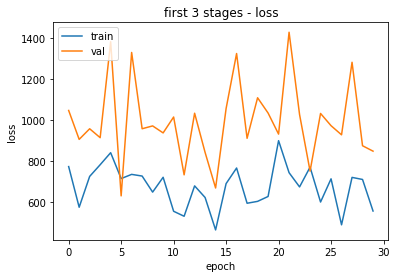

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('first 3 stages - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], 
           loc='upper left')

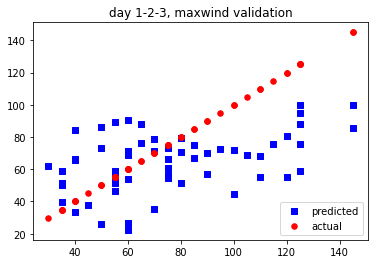

on average, the model's prediction is 41.064850761855055 % off of the true max wind speed.
RMSE: 29.589339156176145 knots


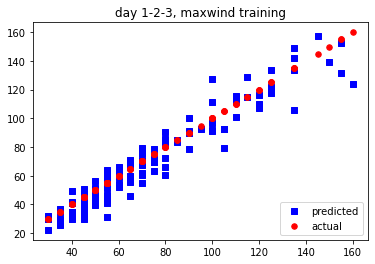

on average, the model's prediction is 11.424739653439781 % off of the true max wind speed.
RMSE: 9.251810669884394 knots


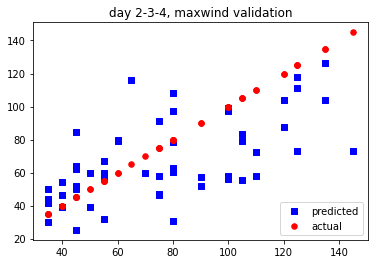

on average, the model's prediction is 35.6720718643013 % off of the true max wind speed.
RMSE: 26.950200248922666 knots


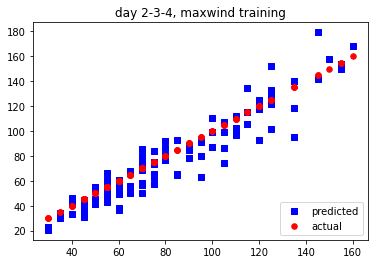

on average, the model's prediction is 12.584664105327006 % off of the true max wind speed.
RMSE: 11.213592959137703 knots


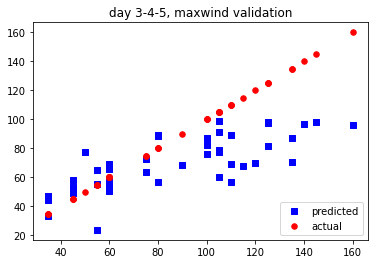

on average, the model's prediction is 32.37076755401424 % off of the true max wind speed.
RMSE: 28.71688076241318 knots


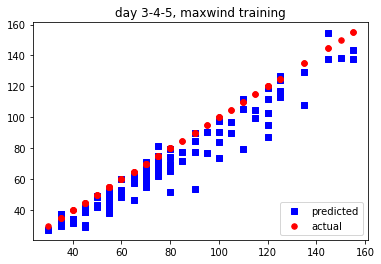

on average, the model's prediction is 14.80741061549648 % off of the true max wind speed.
RMSE: 11.718242827566781 knots


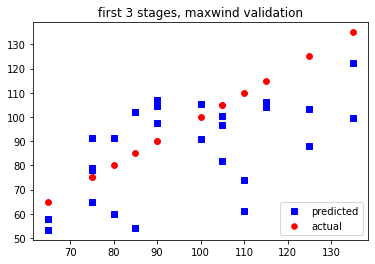

on average, the model's prediction is 21.018551891812912 % off of the true max wind speed.
RMSE: 20.358488354878 knots


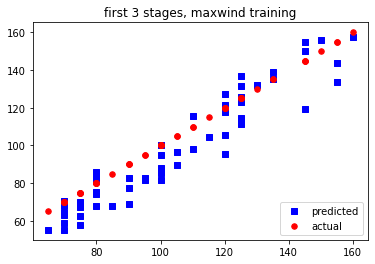

on average, the model's prediction is 10.537056372056012 % off of the true max wind speed.
RMSE: 10.949641349876167 knots


In [20]:

maxwind_predict(maxwind_three_day_model_1,
                [test1['day_1_test'], test1['day_2_test'], test1['day_3_test']], test1['day_maxwind_test'],
                'day 1-2-3, maxwind validation')

maxwind_predict(maxwind_three_day_model_1,
                [test1['day_1_train'], test1['day_2_train'], test1['day_3_train']], test1['day_maxwind_train'],
                'day 1-2-3, maxwind training')


maxwind_predict(maxwind_three_day_model_2,
                [test2['day_1_test'], test2['day_2_test'], test2['day_3_test']], test2['day_maxwind_test'],
                'day 2-3-4, maxwind validation')

maxwind_predict(maxwind_three_day_model_2,
                [test2['day_1_train'], test2['day_2_train'], test2['day_3_train']], test2['day_maxwind_train'],
                'day 2-3-4, maxwind training')

maxwind_predict(maxwind_three_day_model_3,
                [test3['day_1_test'], test3['day_2_test'], test3['day_3_test']], test3['day_maxwind_test'],
                'day 3-4-5, maxwind validation')

maxwind_predict(maxwind_three_day_model_3,
                [test3['day_1_train'], test3['day_2_train'], test3['day_3_train']], test3['day_maxwind_train'],
                'day 3-4-5, maxwind training')


maxwind_predict(maxwind_three_stage_model,
                [stage_1_test, stage_2_test, stage_3_test], stage_maxwind_test,
                'first 3 stages, maxwind validation')

maxwind_predict(maxwind_three_stage_model,
                [stage_1_train, stage_2_train, stage_3_train], stage_maxwind_train,
                'first 3 stages, maxwind training')

# category_predict(category_three_day_model, 
#                  [day_1_test, day_2_test, day_3_test], day_category_test,
#                  'first 3 days, category validation - confusion matrix')
                 
# category_predict(category_three_day_model, 
#                  [day_1_train, day_2_train, day_3_train], day_category_train,
#                  'first 3 days, category training - confusion matrix')

# category_predict(category_three_stage_model, 
#                  [stage_1_test, stage_2_test, stage_3_test], stage_category_test,
#                  'first 3 stages, category validation - confusion matrix')
                 
# category_predict(category_three_stage_model, 
#                  [stage_1_train, stage_2_train, stage_3_train], stage_category_train,
#                  'first 3 stages, category training - confusion matrix')

In [19]:
maxwind_three_day_model_1.save('/home/fun/hurricane_intensity/maxwind_days_1_to_3.h5')
maxwind_three_day_model_2.save('/home/fun/hurricane_intensity/maxwind_days_2_to_4.h5')
maxwind_three_day_model_3.save('/home/fun/hurricane_intensity/maxwind_days_3_to_5.h5')
maxwind_three_stage_model.save('/home/fun/hurricane_intensity/maxwind_three_stage_model.h5')